**Tool input**

In [1]:
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

**Load data function**

In [2]:
# 设置随机种子
seed = 2023  # 可以使用任何整数作为种子
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
def load_data(filename, batch_size):
    with open(filename, 'r') as file:
        lines = file.readlines()
    X = []
    y = []
    for line in lines:
        parts = line.strip().split()
        y.append(int(parts[0]))
        features = [float(part.split(':')[1]) for part in parts[1:]]
        X.append(features)
    X = np.array(X)
    y = np.array(y)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(val_dataset, batch_size=batch_size)
    testloader = DataLoader(test_dataset, batch_size=batch_size)
    return trainloader, validloader, testloader

**Train + Vaild + test function**

In [4]:
def train_validate_test(
    model, trainloader, validloader, testloader, optimizer, criterion, num_epochs
):
    best_valid_loss = float('inf')  # Initialize with a large value
    best_valid_model_state = None
    train_performance = {
        "Loss": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": []
    }
    valid_performance = {
        "Loss": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": []
    }

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        total_true_positives = 0
        total_predicted_positives = 0
        total_actual_positives = 0

        for batch_X, batch_y in trainloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_correct += (predicted == batch_y.view(-1, 1)).sum().item()
            total_samples += len(batch_y)

            true_positives = ((predicted == 1) & (batch_y.view(-1, 1) == 1)).sum().item()
            predicted_positives = (predicted == 1).sum().item()
            actual_positives = (batch_y.view(-1, 1) == 1).sum().item()

            total_true_positives += true_positives
            total_predicted_positives += predicted_positives
            total_actual_positives += actual_positives

        # Calculate training performance metrics
        average_loss = total_loss / len(trainloader)
        accuracy = total_correct / total_samples
        precision = total_true_positives / (total_predicted_positives + 1e-8)
        recall = total_true_positives / (total_actual_positives + 1e-8)

        train_performance["Loss"].append(average_loss)
        train_performance["Accuracy"].append(accuracy)
        train_performance["Precision"].append(precision)
        train_performance["Recall"].append(recall)

        # Validate the model
        valid_loss = 0
        valid_correct = 0
        valid_samples = 0
        valid_true_positives = 0
        valid_predicted_positives = 0
        valid_actual_positives = 0

        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            for batch_X, batch_y in validloader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.view(-1, 1))

                valid_loss += loss.item()

                predicted = (outputs > 0.5).float()
                valid_correct += (predicted == batch_y.view(-1, 1)).sum().item()
                valid_samples += len(batch_y)

                true_positives = ((predicted == 1) & (batch_y.view(-1, 1) == 1)).sum().item()
                predicted_positives = (predicted == 1).sum().item()
                actual_positives = (batch_y.view(-1, 1) == 1).sum().item()

                valid_true_positives += true_positives
                valid_predicted_positives += predicted_positives
                valid_actual_positives += actual_positives

        # Calculate validation performance metrics
        average_valid_loss = valid_loss / len(validloader)
        valid_accuracy = valid_correct / valid_samples
        valid_precision = valid_true_positives / (valid_predicted_positives + 1e-8)
        valid_recall = valid_true_positives / (valid_actual_positives + 1e-8)

        valid_performance["Loss"].append(average_valid_loss)
        valid_performance["Accuracy"].append(valid_accuracy)
        valid_performance["Precision"].append(valid_precision)
        valid_performance["Recall"].append(valid_recall)

        # Check if the current model is the best based on validation loss
        if average_valid_loss < best_valid_loss:
            best_valid_loss = average_valid_loss
            best_valid_model_state = model.state_dict()

    # Save the best model state
    torch.save(best_valid_model_state, 'best_model_state.pt')

    # Test the best model
    model.load_state_dict(best_valid_model_state)  # Load the best model state
    test_correct = 0
    test_samples = 0

    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for batch_X, batch_y in testloader:
            outputs = model(batch_X)
            predicted = (outputs > 0.5).float()
            test_correct += (predicted == batch_y.view(-1, 1)).sum().item()
            test_samples += len(batch_y)

    # Calculate test accuracy
    test_accuracy = test_correct / test_samples

    return train_performance, valid_performance, test_accuracy

**Plot function**

In [5]:
def plot_performance_metrics(performance_dict):
    # Extract performance metric data
    loss_values = performance_dict["Loss"]
    accuracy_values = performance_dict["Accuracy"]
    precision_values = performance_dict["Precision"]
    recall_values = performance_dict["Recall"]

    # Create x-axis data (e.g., iterations or epochs)
    iterations = range(1, len(loss_values) + 1)

    # Create subplots for performance metrics
    plt.figure(figsize=(12, 4))

    #  Loss
    plt.subplot(1, 4, 1)
    plt.plot(iterations, loss_values, label=' Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(' Loss')

    #  Accuracy
    plt.subplot(1, 4, 2)
    plt.plot(iterations, accuracy_values, label=' Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(' Accuracy')

    #  Precision
    plt.subplot(1, 4, 3)
    plt.plot(iterations, precision_values, label=' Precision')
    plt.xlabel('Iterations')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(' Precision')

    #  Recall
    plt.subplot(1, 4, 4)
    plt.plot(iterations, recall_values, label=' Recall')
    plt.xlabel('Iterations')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(' Recall')

    # Display the plots
    plt.tight_layout()
    plt.show()

# Assuming you have already obtained the 'performance' dictionary


**Data input**

In [6]:
batch_size = 32
filename = 'diabetes.txt'
trainloader, validloader, testloader = load_data(filename, batch_size)

**Parameters**

In [7]:
#1 (input_size = 8 hidden_size = 64 output_size = 1 learn_rate = 0.0025 num_epochs = 100 l1_lambda = 0.01 l2_lambda = 0.01 dropout_prob = 0.5)
#2 (input_size = 8 hidden_size = 64 output_size = 1 learn_rate = 0.005 num_epochs = 100 l1_lambda = 0.01 l2_lambda = 0.01 dropout_prob = 0.5)
#3 (input_size = 8 hidden_size = 64 output_size = 1 learn_rate = 0.0075 num_epochs = 100 l1_lambda = 0.01 l2_lambda = 0.01 dropout_prob = 0.5)
#4 (input_size = 8 hidden_size = 64 output_size = 1 learn_rate = 0.005 num_epochs = 50 l1_lambda = 0.01 l2_lambda = 0.01 dropout_prob = 0.5)
#5 (input_size = 8 hidden_size = 64 output_size = 1 learn_rate = 0.005 num_epochs = 100 l1_lambda = 0.01 l2_lambda = 0.01 dropout_prob = 0.5)
#6 (input_size = 8 hidden_size = 64 output_size = 1 learn_rate = 0.005 num_epochs = 150 l1_lambda = 0.01 l2_lambda = 0.01 dropout_prob = 0.5)

input_size = 8
hidden_size = 64
output_size = 1
learn_rate = 0.0025
num_epochs = 100
l1_lambda = 0.01
l2_lambda = 0.01
dropout_prob = 0.5

**MLP(2layer) + Tanh + nn.BCEWithLogitsLoss + optim.SGD**

In [8]:
class TwoLayerMLP1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.tanh = nn.Tanh()  # Tanh激活函数
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model1 = TwoLayerMLP1(input_size, hidden_size, output_size)
criterion1 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer1 = optim.SGD(model1.parameters(), lr=learn_rate)  # 使用随机梯度下降（SGD）优化器

In [9]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model1, trainloader, validloader, testloader, optimizer1, criterion1, num_epochs
)

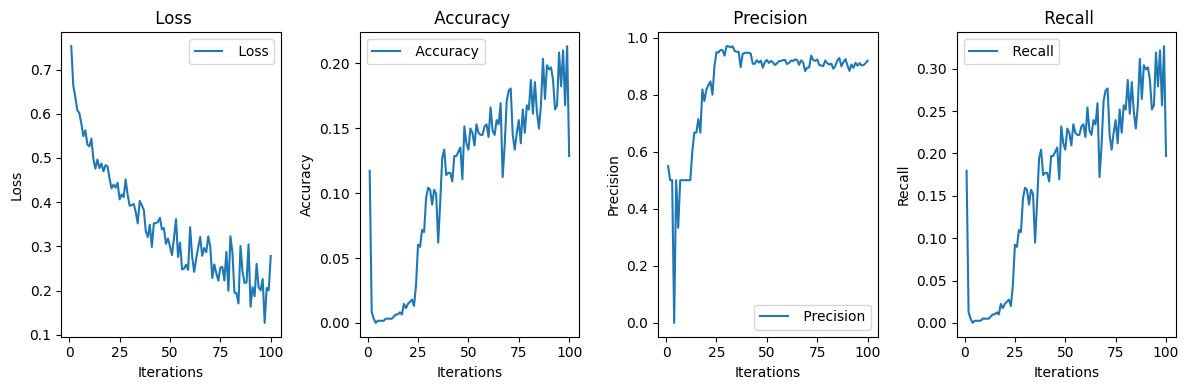

In [10]:
plot_performance_metrics(train_performance)

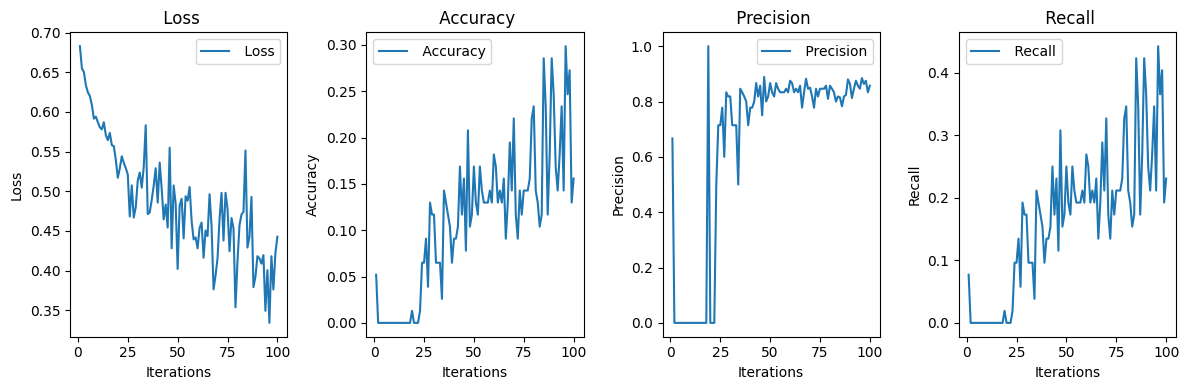

In [11]:
plot_performance_metrics(valid_performance)

In [12]:
test_accuracy

0.14285714285714285

**MPL(2layer) + Tanh + nn.BCEWithLogitsLoss + optim.SGD + L1**

In [13]:
class TwoLayerMLP2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model2 = TwoLayerMLP2(input_size, hidden_size, output_size)
criterion2 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer2 = optim.SGD(model2.parameters(), lr=learn_rate, weight_decay=l1_lambda)  # 使用随机梯度下降（SGD）优化器

In [14]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model2, trainloader, validloader, testloader, optimizer2, criterion2, num_epochs
)

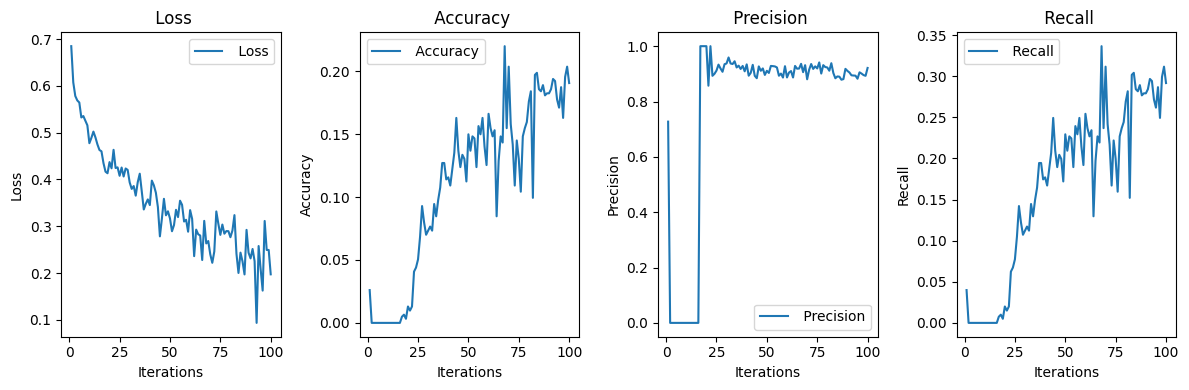

In [15]:
plot_performance_metrics(train_performance)

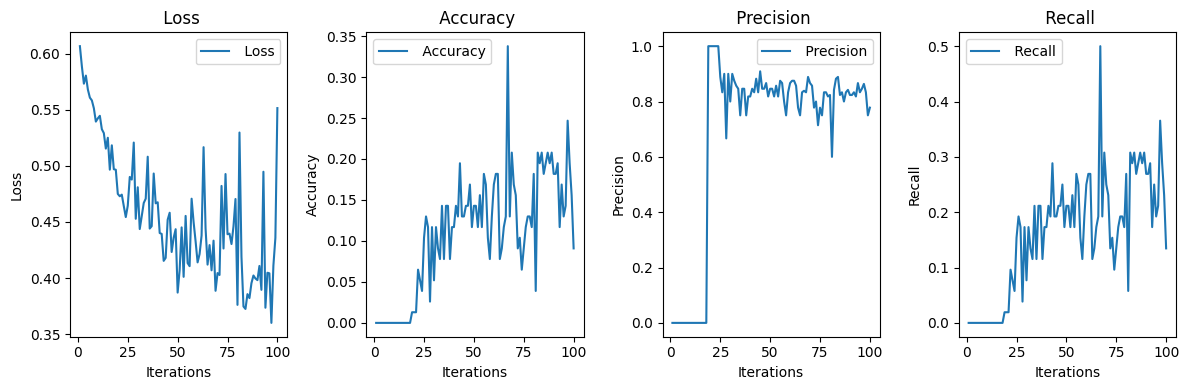

In [16]:
plot_performance_metrics(valid_performance)

In [17]:
test_accuracy

0.07792207792207792

**MPL(2layer) + Tanh + nn.BCEWithLogitsLoss + optim.SGD + L2**

In [18]:
class TwoLayerMLP3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.tanh = nn.Tanh()  # Tanh激活函数
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)

model3 = TwoLayerMLP3(input_size, hidden_size, output_size)
criterion3 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer3 = optim.SGD(model3.parameters(), lr=learn_rate, weight_decay=l2_lambda)  # 使用随机梯度下降（SGD）优化器

In [19]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model3, trainloader, validloader, testloader, optimizer3, criterion3, num_epochs
)

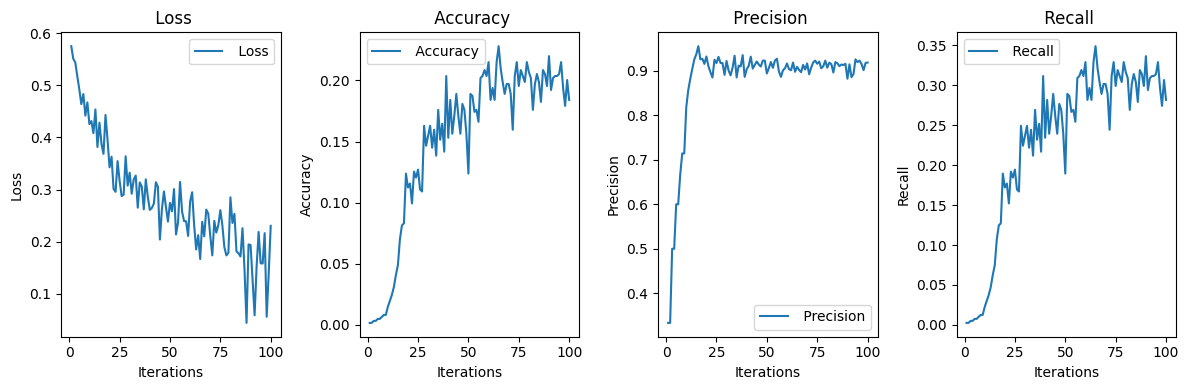

In [20]:
plot_performance_metrics(train_performance)

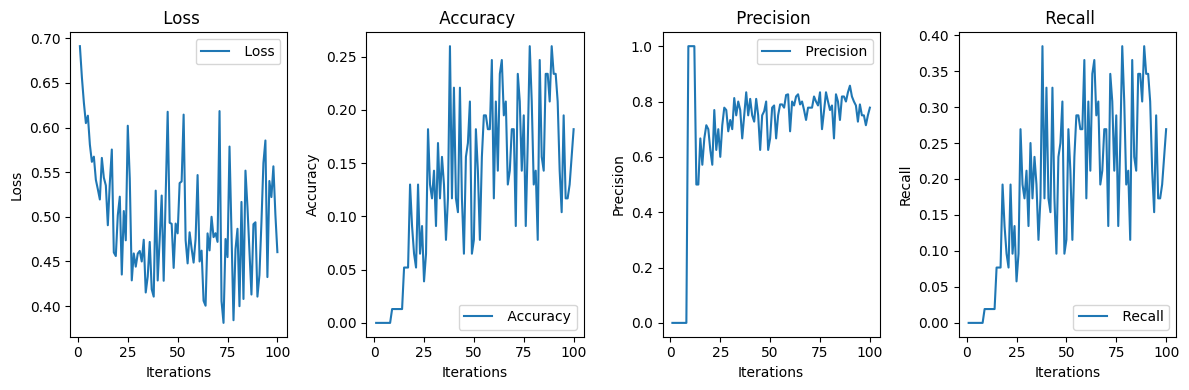

In [21]:
plot_performance_metrics(valid_performance)

In [22]:
test_accuracy

0.22077922077922077

**MPL(2layer) + Tanh + nn.BCEWithLogitsLoss + optim.SGD + Dropout**

In [23]:
class TwoLayerMLP4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(TwoLayerMLP4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.tanh = nn.Tanh()  # Tanh激活函数
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model4 = TwoLayerMLP4(input_size, hidden_size, output_size, dropout_prob)
criterion4 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer4 = optim.SGD(model4.parameters(), lr=learn_rate)  # 使用随机梯度下降（SGD）优化器

In [24]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model4, trainloader, validloader, testloader, optimizer4, criterion4, num_epochs
)

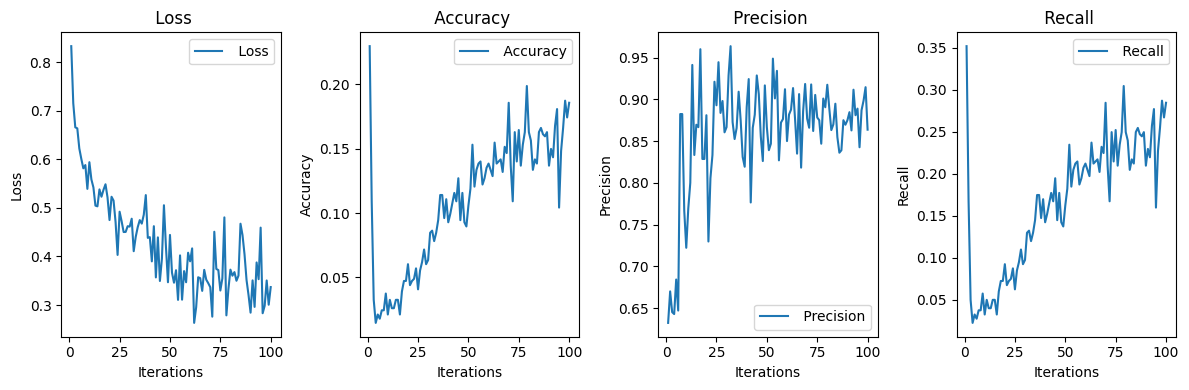

In [25]:
plot_performance_metrics(train_performance)

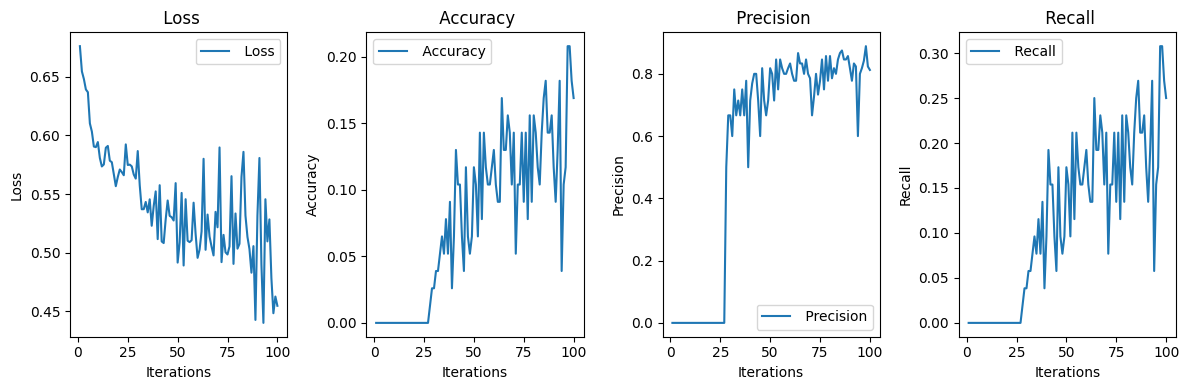

In [26]:
plot_performance_metrics(valid_performance)

In [27]:
test_accuracy

0.16883116883116883

**MPL(2layer) + Relu + nn.BCEWithLogitsLoss + optim.SGD**

In [28]:
class TwoLayerMLP5(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP5, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model5 = TwoLayerMLP5(input_size, hidden_size, output_size)
criterion5 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer5 = optim.SGD(model5.parameters(), lr=learn_rate)  # 使用随机梯度下降（SGD）优化器

In [29]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model5, trainloader, validloader, testloader, optimizer5, criterion5, num_epochs
)

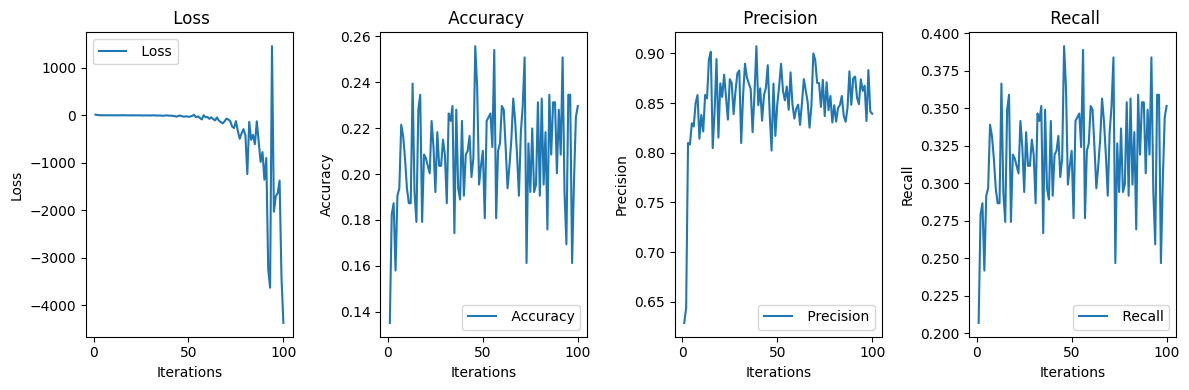

In [30]:
plot_performance_metrics(train_performance)

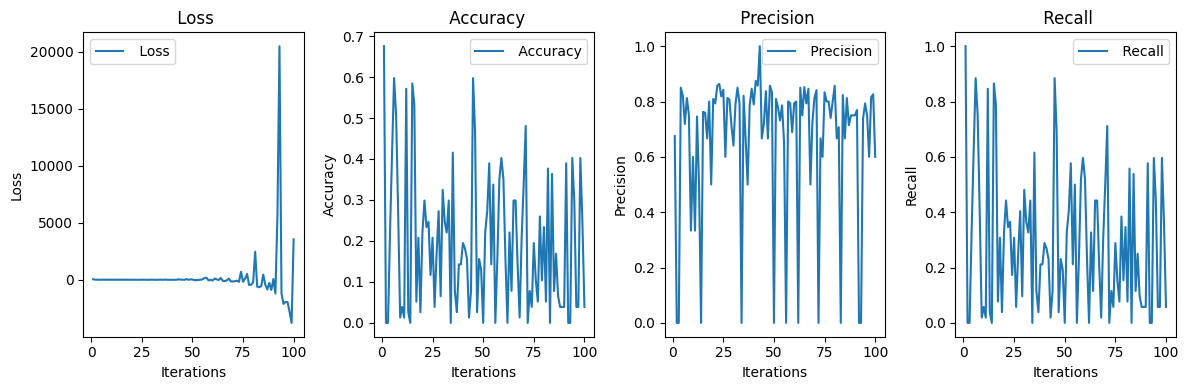

In [31]:
plot_performance_metrics(valid_performance)

In [32]:
test_accuracy

0.025974025974025976

**MPL(2layer) + Relu + nn.BCEWithLogitsLoss + optim.SGD + L1**

In [33]:
class TwoLayerMLP6(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP6, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model6 = TwoLayerMLP6(input_size, hidden_size, output_size)
criterion6 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer6 = optim.SGD(model6.parameters(), lr=learn_rate, weight_decay=l1_lambda)  # 使用随机梯度下降（SGD）优化器


In [34]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model6, trainloader, validloader, testloader, optimizer6, criterion6, num_epochs
)

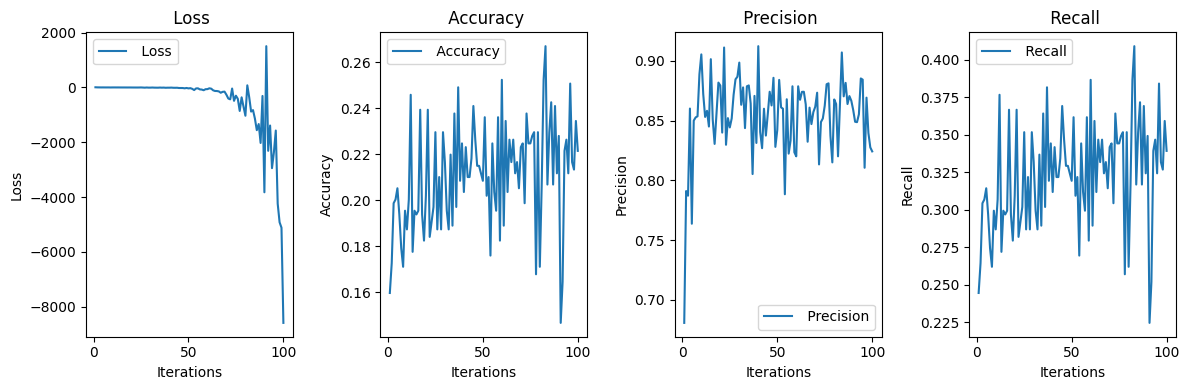

In [35]:
plot_performance_metrics(train_performance)

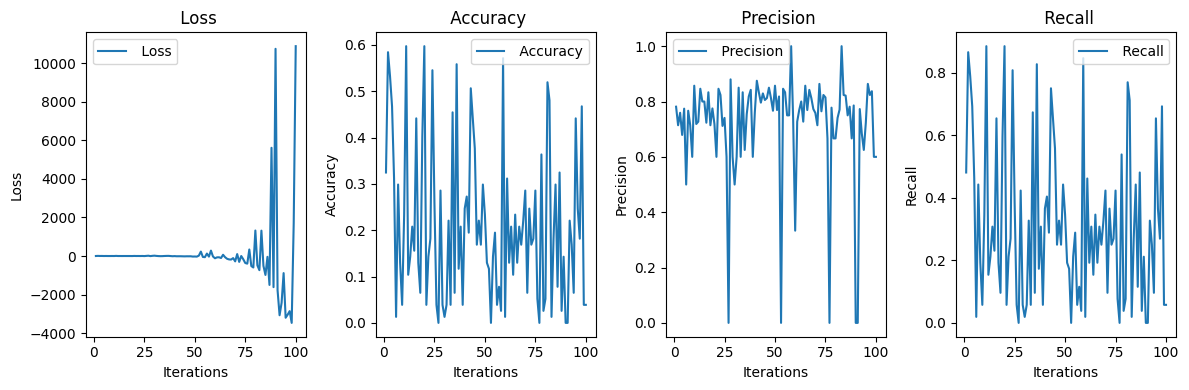

In [36]:
plot_performance_metrics(valid_performance)

In [37]:
test_accuracy

0.03896103896103896

**MPL(2layer) + Relu + nn.BCEWithLogitsLoss + optim.SGD + L2**

In [38]:
class TwoLayerMLP7(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP7, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model7 = TwoLayerMLP7(input_size, hidden_size, output_size)
criterion7 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer7 = optim.SGD(model7.parameters(), lr=learn_rate, weight_decay=l2_lambda)  # 使用随机梯度下降（SGD）优化器

In [39]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model7, trainloader, validloader, testloader, optimizer7, criterion7, num_epochs
)

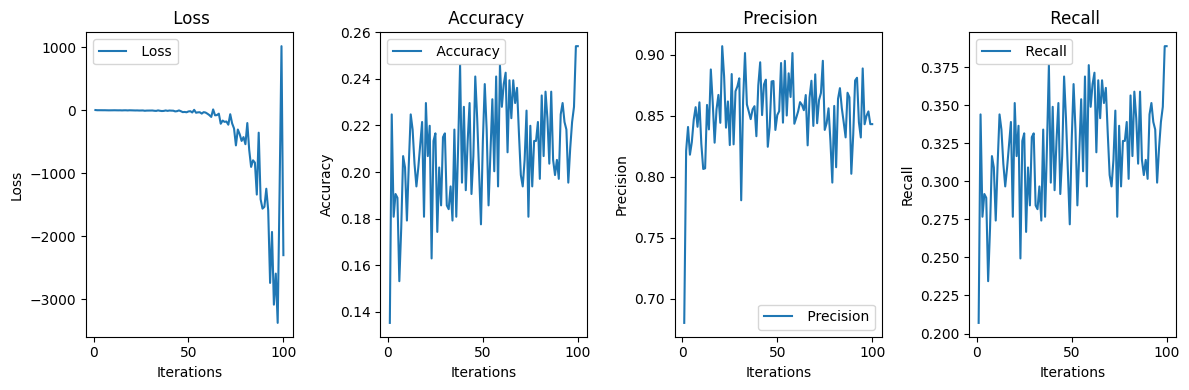

In [40]:
plot_performance_metrics(train_performance)

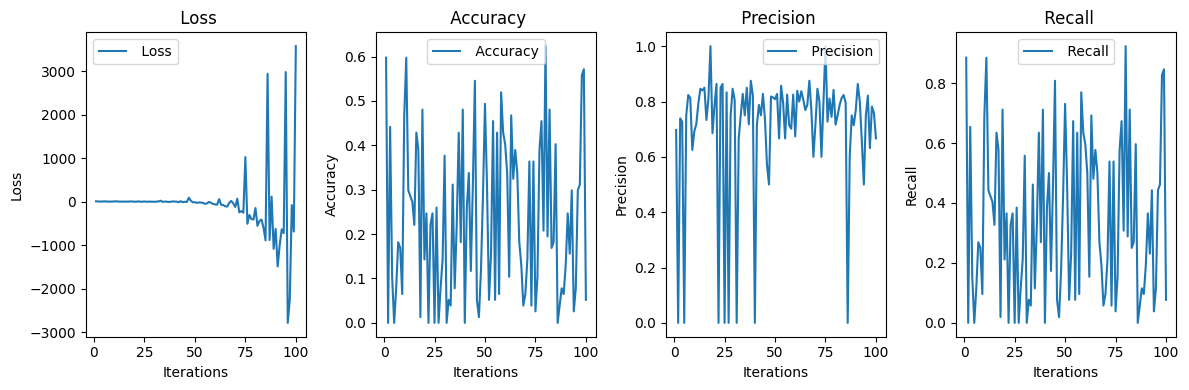

In [41]:
plot_performance_metrics(valid_performance)

In [42]:
test_accuracy

0.05194805194805195

**MPL(2layer) + Relu + nn.BCEWithLogitsLoss + optim.SGD + Dropout**

In [43]:
class TwoLayerMLP8(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(TwoLayerMLP8, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 输入层到隐藏层的全连接层
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)  # 隐藏层到输出层的全连接层
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    def initialize_parameters(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          init.xavier_normal_(module.weight)
          if module.bias is not None:
            init.constant_(module.bias, 0)
model8 = TwoLayerMLP8(input_size, hidden_size, output_size, dropout_prob)
criterion8 = nn.BCEWithLogitsLoss()  # 用于二元分类问题的二元交叉熵损失函数
optimizer8 = optim.SGD(model8.parameters(), lr=learn_rate)  # 使用随机梯度下降（SGD）优化器

In [44]:
train_performance, valid_performance, test_accuracy = train_validate_test(
    model8, trainloader, validloader, testloader, optimizer8, criterion8, num_epochs
)

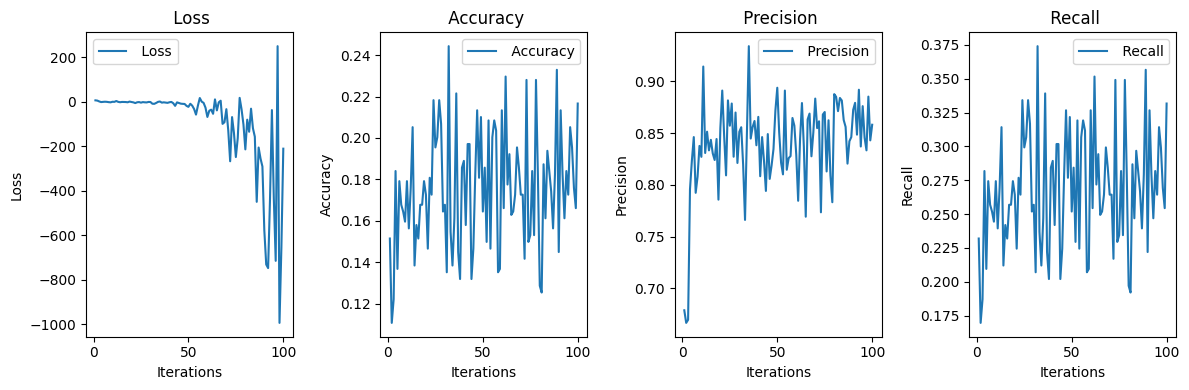

In [45]:
plot_performance_metrics(train_performance)

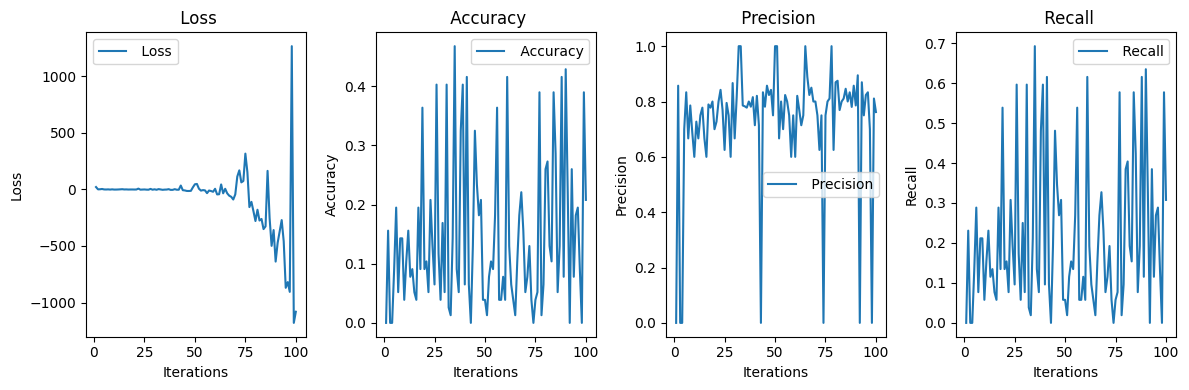

In [46]:
plot_performance_metrics(valid_performance)

In [47]:
test_accuracy

0.2077922077922078